In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
from scipy.stats import ttest_1samp, ttest_rel, ttest_ind
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
from IPython.display import Image, display

In [4]:
import warnings

In [5]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [6]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [7]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [8]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [9]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [10]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [11]:
mpl.rcParams['font.family'] = 'Helvetica'

## Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [12]:
list_sn = su.get_list_sn()
# list_roi = simage.get_list_roi()
list_run = su.get_list_run()

In [13]:
dir_group = join(ssingle.get_dir_glmsingle(),'surfaceWB/group')
dir_group

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/group'

---

In [14]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [15]:
dir_group = join(dir_surf,'group')

---

|(K,P)|ch $_{1}$|ch $_{2}$|$\cdots$|$i^{th}$ profile|$\cdots$|ch $_{P-1}$|ch $_{P}$| 
|-----|-----|-----|-----|-----|-----|-----|-----|
|cond $_{1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{2}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|$j^{th}$ pattern|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|$\vdots$|$\vdots$|$\vdots$|$\ddots$|$\vdots$|$\ddots$|$\cdot$|$\cdot$|
|cond $_{K-1}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|
|cond $_{K}$|$\cdot$|$\cdot$|$\cdots$|$\cdot$|$\cdots$|$\cdot$|$\cdot$|

1) Whole Brain: Pattern Analysis
2) ROI: Profile Analysis

In [16]:
dir_roi = su.get_dir_roi()

In [17]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')
hem = 'L'

In [18]:
# fname = join(dir_roi, 'SPark.32k.L.dlabel.nii')
# cii = nb.load(fname)
# mask = cii.get_fdata()[0].astype(int)

fname = join(dir_roi,'SPark2025.32k.L.label.gii')
gii = nb.load(fname)
mask = gii.darrays[0].data

In [19]:
list_roi = []
for ii, label in enumerate(gii.labeltable.labels):
    if ii>0:
        list_roi.append(label.label)
list_roi = np.array(list_roi)
list_roi

array(['S1', 'M1', 'SMA', 'PMd', 'PMv', 'SPLa', 'SPLp', 'IPS', 'V4d',
       'Vf', 'Vd', 'Vv', 'POS', 'PGi'], dtype='<U4')

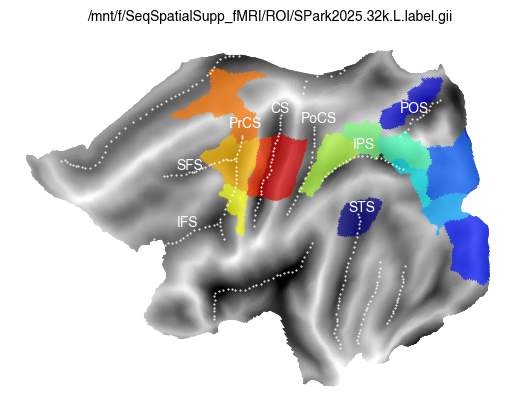

In [20]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet_r.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='white', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='white', fontsize=10)

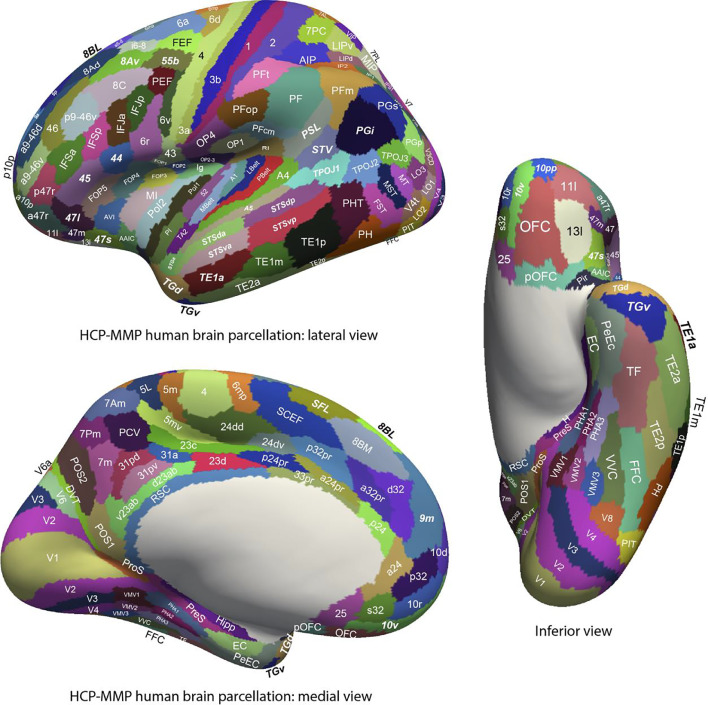

In [21]:
display(Image(filename='../figures/1-s2.0-S1053811922004712-gr1.jpg'))

---
---

In [22]:
def extract_data(data, mask, list_roi):
    result = {}
    for ii, roi in enumerate(list_roi):
        assert data.shape[-1] == mask.shape[0]
        val = ii+1
        idx = mask==val

        result[roi] = data[:,idx].mean(axis=-1)

    return result

In [23]:
df = pd.DataFrame()

## 1. Overall Activity

In [24]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[],'notes':[]}

In [25]:
glm = 1
category = 'overall'

In [26]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [27]:
notes = None
for ii, cue in enumerate(['letter','spatial']):
    fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s.dscalar.nii'%(hem,glm,cue))
    cii = nb.load(fname)
    data = cii.get_fdata()
    res = extract_data(data=data, mask=mask, list_roi=list_roi)
    for roi, values in res.items():
        for jj, value in enumerate(values):
            sn = list_sn[jj]
            subj = 'S'+sn
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
            lines['notes'].append(notes)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

 57%|█████████████████████████████▋                      | 8/14 [00:00<00:00, 35.89it/s]

S1
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 11.9695 1.0000 11.0000 0.0053

t(11)=3.4597, p=0.0053(**)

M1
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  9.3617 1.0000 11.0000 0.0109

t(11)=3.0597, p=0.0109(*)

SMA
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 17.4234 1.0000 11.0000 0.0016

t(11)=4.1741, p=0.0016(**)

PMd
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  7.6470 1.0000 11.0000 0.0184

t(11)=2.7653, p=0.0184(*)

PMv
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 38.3324 1.0000 11.0000 0.0001

t(11)=6.1913, p=0.0001(****)

SPLa
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  5.8223 1.0000 11.0000 0.0344

t(11)=2.4130, p=0.0344(*)

SPLp
              Anova
     F Value Num DF  Den DF P

100%|███████████████████████████████████████████████████| 14/14 [00:01<00:00,  9.27it/s]


V4d
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 30.4683 1.0000 11.0000 0.0002

t(11)=-5.5198, p=0.0002(***)

Vf
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 10.1253 1.0000 11.0000 0.0087

t(11)=3.1820, p=0.0087(**)

Vd
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 13.9643 1.0000 11.0000 0.0033

t(11)=-3.7369, p=0.0033(**)

Vv
               Anova
     F Value  Num DF  Den DF Pr > F
-----------------------------------
cond 108.9667 1.0000 11.0000 0.0000

t(11)=-10.4387, p=0.0000(****)

POS
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.2470 1.0000 11.0000 0.6290

t(11)=-0.4970, p=0.6290(ns)

PGi
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  3.2853 1.0000 11.0000 0.0973

t(11)=1.8125, p=0.0973(ns)



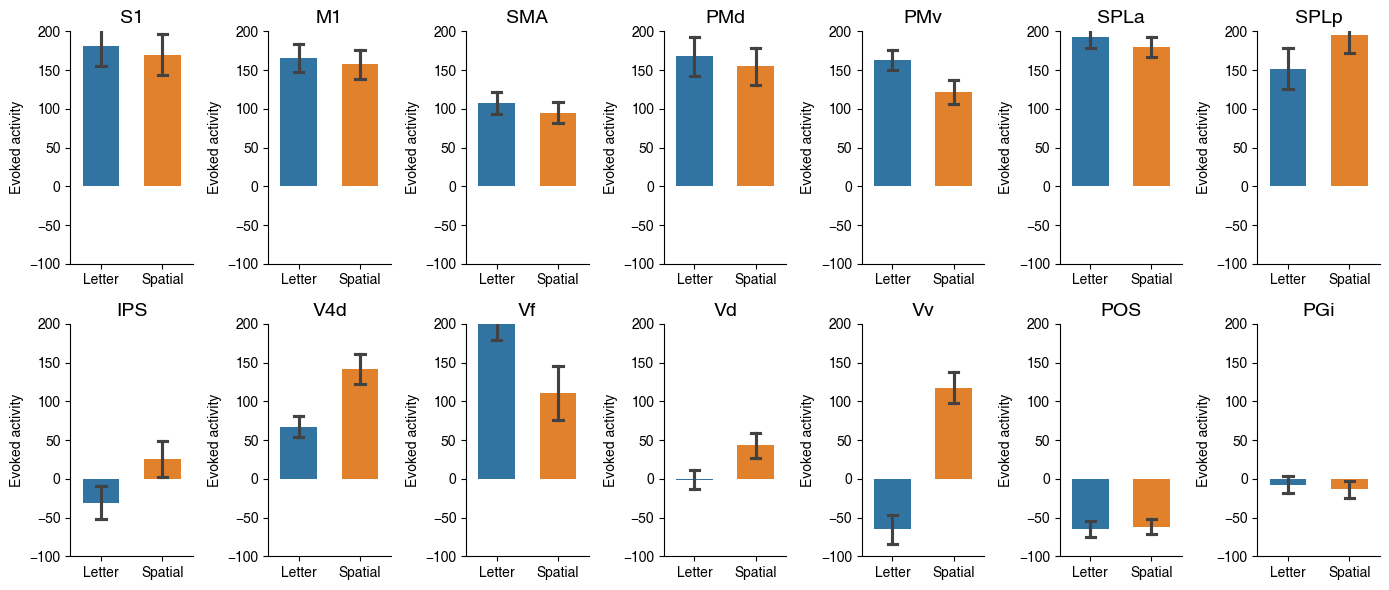

In [28]:
nrows = 2
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 3*nrows))
axs = np.concatenate(axs)

order = ['letter','spatial']
for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    data = dg[dg.roi==roi].set_index('subj', drop=False)
    g = sns.barplot(
        data=data,
        x='cond', y='value', order=order,
        hue='cond',
        width=0.6,
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # g.grid(axis='both')
    # g.legend().remove()
    # g.legend()
    g.set_ylim(-100,200)
    g.set_ylabel('Evoked activity')
    g.set_xlabel('')
    g.set_xticks([0,1])
    g.set_xticklabels(['Letter','Spatial'])
    g.set_title(roi, fontsize=14)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    ## rmANOVA
    print(roi)
    aov = AnovaRM(
        data=data,
        depvar='value',
        subject='subj',
        within=['cond']
    ).fit()
    print(aov)
    # for key, pval in aov.anova_table['Pr > F'].items():
    #     print(key, 'p=%.3e (%s)'%(pval,sstat.convert_pval_to_star(pval)))
    
    ## overall: letter vs. spatial
    a = data[data.cond=='letter'].value.astype(float)
    b = data[data.cond=='spatial'].value.astype(float)
    res = ttest_rel(a,b, alternative='two-sided')
    pval = res.pvalue
    # pval = res.pvalue * len(list_roi)
    print('t(%d)=%.4f, p=%.4f(%s)\n'%(res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))
    
fig.tight_layout()

## 2. RS Effect

In [29]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[],'notes':[]}

In [30]:
glm = 2
category = 'RS_effect'

In [31]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [32]:
list_cond = ['within','between']
# list_cond = ['B','S','C','N']
for ii, cue in enumerate(['letter','spatial']):
    ## Assuming ‘N_cue’ as the baseline (reference).
    fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.N_%s.dscalar.nii'%(hem,glm,cue))
    cii = nb.load(fname)
    data = cii.get_fdata()
    ref = extract_data(data=data, mask=mask, list_roi=list_roi)
    
    for jj, cond in enumerate(list_cond):
        fname = join(dir_work,'smooth.cifti.%s.glm_%1d.beta_mean.%s_%s.dscalar.nii'%(hem,glm,cond,cue))
        cii = nb.load(fname)
        data = cii.get_fdata()
        res = extract_data(data=data, mask=mask, list_roi=list_roi)
        for roi, values in res.items():
            a = ref[roi]
            tt = ttest_1samp(a=a, popmean=0, alternative='two-sided')
            if tt.pvalue > 0.05:
                notes = None
            else:
                ## The baseline was coded as ‘+’ when greater than 0, and as ‘–’ when less than 0.
                notes = '+' if tt.statistic > 0 else ('-' if tt.statistic < 0 else 'invalid')
            for kk, value in enumerate(values):
                sn = list_sn[kk]
                subj = 'S'+sn
                lines['category'].append(category)
                lines['roi'].append(roi)
                lines['cond'].append('%s_%s'%(cond,cue))
                lines['subj'].append(subj)
                lines['value'].append(value)
                lines['notes'].append(notes)
dg = pd.DataFrame(lines)

In [33]:
idx = dg.cond.isin(['between_letter','between_spatial'])
tmp = dg[idx].groupby(['category','roi','subj'], as_index=False)['value'].mean()
tmp['cond'] = 'across'
dg = pd.concat([dg[~idx],tmp])
dg['cond'] = dg.cond.replace({
    'within_letter': 'letter',
    'within_spatial': 'spatial'
})

In [34]:
## rmANOVA
aov = AnovaRM(
    data=dg,
    depvar='value',
    subject='subj',
    within=['cond','roi']
).fit()
pval = aov.anova_table['Pr > F']['cond']
print('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)),aov)

PGi (ns)                  Anova
         F Value  Num DF  Den DF  Pr > F
----------------------------------------
cond      1.4606  2.0000  22.0000 0.2537
roi       3.3883 13.0000 143.0000 0.0001
cond:roi  0.6735 26.0000 286.0000 0.8865



In [35]:
mapper = {'+': 1, '-': -1}
dg['value'] = dg['value'] * dg['notes'].map(mapper).fillna(1)

In [36]:
df = pd.concat([df,dg])

  0%|                                                            | 0/14 [00:00<?, ?it/s]

S1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.4437 2.0000 22.0000 0.6473

letter vs. spatial: t(11)=0.1004, p=9.218e-01(ns)

M1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.1831 2.0000 22.0000 0.8339

letter vs. spatial: t(11)=0.2793, p=7.852e-01(ns)



 50%|██████████████████████████                          | 7/14 [00:00<00:00, 30.67it/s]

SMA (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.5032 2.0000 22.0000 0.6114

letter vs. spatial: t(11)=-0.3529, p=7.308e-01(ns)

PMd (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.9975 2.0000 22.0000 0.3849

letter vs. spatial: t(11)=0.4677, p=6.491e-01(ns)

PMv (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.8125 2.0000 22.0000 0.1868

letter vs. spatial: t(11)=-0.4018, p=6.955e-01(ns)

SPLa (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  2.0246 2.0000 22.0000 0.1559

letter vs. spatial: t(11)=0.4602, p=6.543e-01(ns)

SPLp (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  2.4796 2.0000 22.0000 0.1069

letter vs. spatial: t(11)=1.8340, p=9.382e-02(ns)

IPS (ns)               Anova
     F Value Num DF  Den DF Pr > F
--

100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 30.91it/s]

Vf (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.4879 2.0000 22.0000 0.6204

letter vs. spatial: t(11)=0.4549, p=6.580e-01(ns)

Vd (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.0222 2.0000 22.0000 0.9781

letter vs. spatial: t(11)=0.2008, p=8.445e-01(ns)

Vv (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.7441 2.0000 22.0000 0.4867

letter vs. spatial: t(11)=0.6779, p=5.118e-01(ns)

POS (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.0158 2.0000 22.0000 0.9843

letter vs. spatial: t(11)=-0.0863, p=9.328e-01(ns)

PGi (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.3392 2.0000 22.0000 0.7160

letter vs. spatial: t(11)=-0.2970, p=7.720e-01(ns)



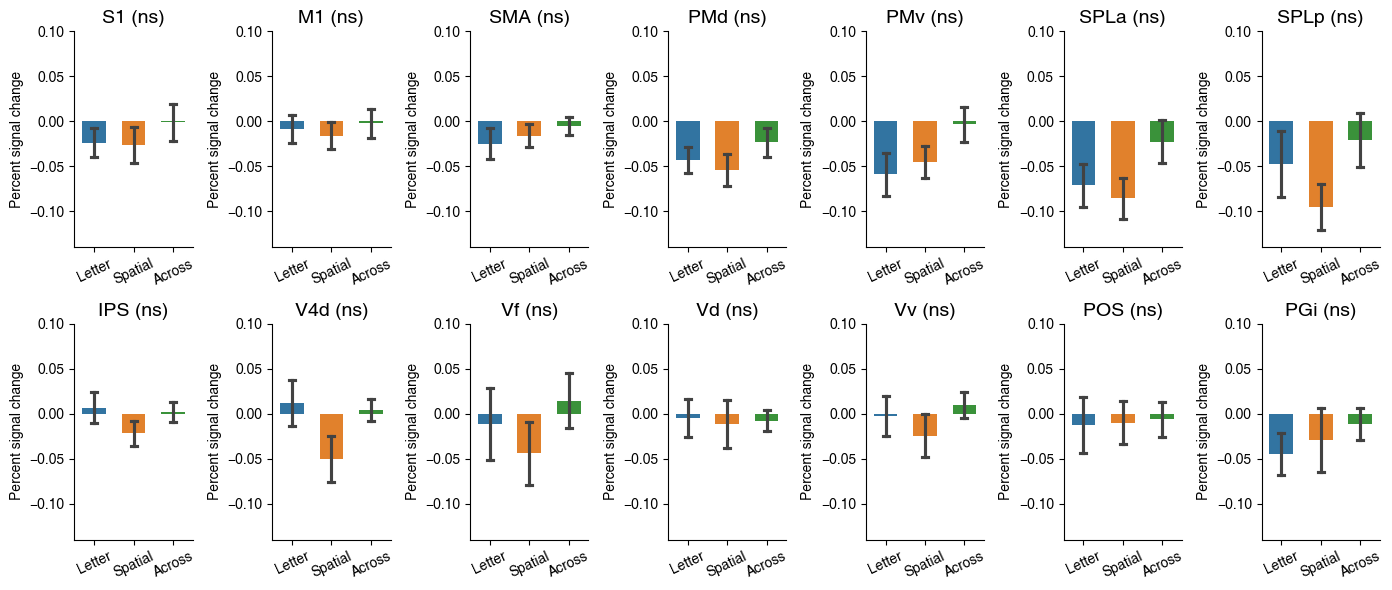

In [37]:
nrows = 2
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 3*nrows))
axs = np.concatenate(axs)

order = ['letter','spatial','across']
for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    data = dg[dg.roi==roi]
    g = sns.barplot(
        data=data,
        x='cond', y='value', order=order,
        hue='cond',
        width=0.6,
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # g.grid(axis='both')
    # g.legend().remove()
    # g.legend()
    g.set_ylim(-0.14,0.1)
    g.set_ylabel('Percent signal change')
    g.set_xlabel('')
    g.set_xticks([0,1,2])
    g.set_xticklabels(['Letter','Spatial','Across'], rotation=25)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    ## rmANOVA
    aov = AnovaRM(
        data=data,
        depvar='value',
        subject='subj',
        within=['cond']
    ).fit()
    pval = aov.anova_table['Pr > F']['cond']
    print('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)),aov)
    g.set_title('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)), fontsize=14)
    
    ## t-test (overall): letter vs. spatial
    a = data[data.cond=='letter'].value.astype(float)
    b = data[data.cond=='spatial'].value.astype(float)
    res = ttest_rel(a,b, alternative='two-sided')
    pval = res.pvalue
    # # pval = res.pvalue * len(list_roi)
    print('letter vs. spatial: t(%d)=%.4f, p=%.3e(%s)\n'%(res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))
    
fig.tight_layout()

In [38]:
# g = sns.pointplot(
#     data=dg,
#     x='roi', y='value', hue='cond',
#     errorbar='se', capsize=0.15
# )
# g.grid(axis='both')
# g.axhline(y=0, color='black', linestyle='--')
# g.legend()
# l = g.get_xticklabels()
# g.set_xticklabels(l, rotation=40)

In [39]:
# tmp = dg.pivot(index=['category','roi','cond','notes'], columns=['subj'], values='value')
# ## For each ROI and condition, the data from 12 subjects were normalized 
# ## by setting the maximum to 1 and the minimum to 0.
# dg_norm = tmp.sub(tmp.min(axis=1), axis=0).div(tmp.max(axis=1) - tmp.min(axis=1), axis=0)
# dg_norm = dg_norm.reset_index().melt(
#     id_vars=['category','roi','cond','notes'],
#     var_name='subj',
#     value_name='value'
# )
# dg_norm

In [40]:
# g = sns.pointplot(
#     data=dg_norm,
#     x='roi', y='value', hue='cond',
#     errorbar='se', capsize=0.15
# )
# g.grid(axis='both')
# g.legend()
# l = g.get_xticklabels()
# g.set_xticklabels(l, rotation=40)

## 3. RSA

In [41]:
# def map_data2surf(data, mySearchlight):
#     surf = np.ones((data.shape[0],32492)) * np.nan
    
#     ## check the indeces of centers
#     idx = mySearchlight.center_indx
#     for ii, dd in enumerate(data):
#         surf[ii,idx] = dd

#     return surf

In [42]:
lines = {'category':[],'roi':[],'cond':[],'subj':[],'value':[],'notes':[]}

In [43]:
glm = 1
category = 'RSA'

In [44]:
dir_work = join(dir_surf,'glm_%1d'%glm)

In [45]:
notes = None
for ii, cue in enumerate(['letter','spatial','across']):
    fname = join(dir_work,'cifti.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(hem,glm,cue))
    data = np.array(nb.load(fname).get_fdata())
    res = extract_data(data=data, mask=mask, list_roi=list_roi)
    for roi, values in res.items():
        for kk, value in enumerate(values):
            sn = list_sn[kk]
            subj = 'S'+sn
            lines['category'].append(category)
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
            lines['notes'].append(notes)
dg = pd.DataFrame(lines)
df = pd.concat([df,dg])

  0%|                                                            | 0/14 [00:00<?, ?it/s]

S1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  2.7897 2.0000 22.0000 0.0832

letter vs. spatial: t(11)=-1.3788, p=1.954e-01(ns)



 36%|██████████████████▌                                 | 5/14 [00:00<00:00, 12.56it/s]

M1 (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.9891 2.0000 22.0000 0.1607

letter vs. spatial: t(11)=-1.3443, p=2.059e-01(ns)

SMA (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.6946 2.0000 22.0000 0.5099

letter vs. spatial: t(11)=0.3521, p=7.314e-01(ns)

PMd (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.9808 2.0000 22.0000 0.3908

letter vs. spatial: t(11)=-0.8915, p=3.917e-01(ns)

PMv (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.3783 2.0000 22.0000 0.6894

letter vs. spatial: t(11)=0.4598, p=6.546e-01(ns)

SPLa (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  3.3224 2.0000 22.0000 0.0548

letter vs. spatial: t(11)=-1.7457, p=1.087e-01(ns)

SPLp (*)               Anova
     F Value Num DF  Den DF Pr > F
---

 79%|████████████████████████████████████████           | 11/14 [00:00<00:00, 19.41it/s]

IPS (*)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  3.6558 2.0000 22.0000 0.0426

letter vs. spatial: t(11)=-2.0832, p=6.136e-02(ns)

V4d (**)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  5.9676 2.0000 22.0000 0.0085

letter vs. spatial: t(11)=-2.4782, p=3.067e-02(*)

Vf (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.7280 2.0000 22.0000 0.2009

letter vs. spatial: t(11)=-1.2540, p=2.359e-01(ns)

Vd (**)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  9.4649 2.0000 22.0000 0.0011

letter vs. spatial: t(11)=-2.7665, p=1.834e-02(*)

Vv (****)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 17.2498 2.0000 22.0000 0.0000

letter vs. spatial: t(11)=-4.1929, p=1.504e-03(**)

POS (ns)               Anova
     F Value Num DF  Den DF Pr > F
-----

100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 17.13it/s]


letter vs. spatial: t(11)=-0.6366, p=5.374e-01(ns)

PGi (ns)               Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.4844 2.0000 22.0000 0.2485

letter vs. spatial: t(11)=1.1254, p=2.844e-01(ns)



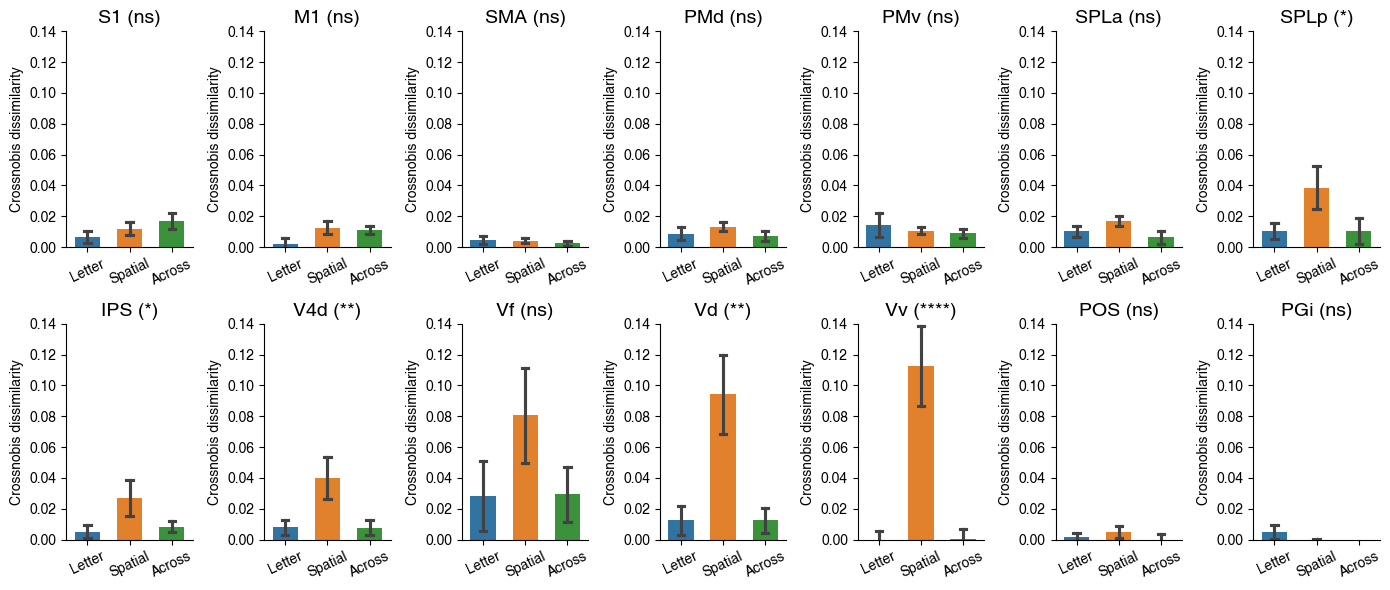

In [46]:
nrows = 2
ncols = 7
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols, 3*nrows))
axs = np.concatenate(axs)

order = ['letter','spatial','across']
for ii, roi in enumerate(tqdm(list_roi)):
    ax = axs[ii]
    data = dg[dg.roi==roi].set_index('subj', drop=False)
    g = sns.barplot(
        data=data,
        x='cond', y='value', order=order,
        hue='cond',
        width=0.6,
        capsize=0.15, errorbar='se',
        ax=ax
    )
    # g.grid(axis='both')
    # g.legend().remove()
    # g.legend()
    g.set_ylim(0,0.14)
    g.set_ylabel('Crossnobis dissimilarity')
    g.set_xlabel('')
    g.set_xticks([0,1,2])
    g.set_xticklabels(['Letter','Spatial','Across'], rotation=25)
    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)

    ## rmANOVA
    aov = AnovaRM(
        data=data,
        depvar='value',
        subject='subj',
        within=['cond']
    ).fit()
    pval = aov.anova_table['Pr > F']['cond']
    print('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)),aov)
    g.set_title('%s (%s)'%(roi,sstat.convert_pval_to_star(pval)), fontsize=14)
    
    ## t-test (overall): letter vs. spatial
    a = data[data.cond=='letter'].value.astype(float)
    b = data[data.cond=='spatial'].value.astype(float)
    res = ttest_rel(a,b, alternative='two-sided')
    pval = res.pvalue
    # # pval = res.pvalue * len(list_roi)
    print('letter vs. spatial: t(%d)=%.4f, p=%.3e(%s)\n'%(res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))
    
fig.tight_layout()

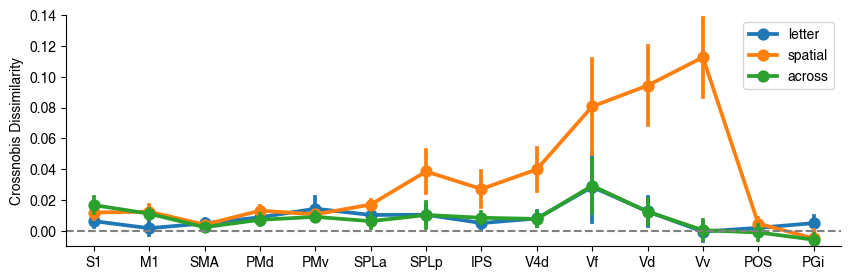

In [47]:
nrows = 1
ncols = 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 3*nrows))

g = sns.pointplot(
    data=dg,
    x='roi', y='value', order=list_roi,
    hue='cond', hue_order=['letter','spatial','across'],
    capsize=0, errorbar='se',
    ax=ax
)
# g.grid(axis='both')
# g.legend().remove()
g.legend()
g.axhline(y=0, linestyle='--', color='gray')
g.set_ylim(-0.01,0.14)
g.set_ylabel('Crossnobis Dissimilarity')
g.set_xlabel('')
# g.set_xticks([0,1,2])
# g.set_xticklabels(['Letter','Spatial','Across'], rotation=25)
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

---

### i) Save the `df`

In [48]:
fname = join(dir_group,'GLMsingle.ROI.csv')
df.to_csv(fname, index=False, encoding="utf-8")

---
---

In [49]:
def plot_df(df=None):
    nrows = 2
    ncols = 7
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axs = np.concatenate(axs)
    
    order = ['overall','RSA','RS_effect']
    hue_order = ['letter','spatial','across']
    for ii, roi in enumerate(tqdm(list_roi)):
        ax = axs[ii]
        data = df[df.roi==roi]
        g = sns.barplot(
            data=data,
            x='category', y='value', hue='cond',
            order=order,
            hue_order=hue_order,
            capsize=0.15, errorbar='se',
            ax=ax
        )
        # g.set_ylim(-0.01,0.01)
        g.grid(axis='both')
        # g.legend().remove()
        g.legend()
        g.set_title(roi, fontsize=14)

        ## overall: letter vs. spatial
        a = df_norm[(df_norm.roi==roi)&(df_norm.category=='overall')&(df_norm.cond=='letter')].value
        b = df_norm[(df_norm.roi==roi)&(df_norm.category=='overall')&(df_norm.cond=='spatial')].value
        res = ttest_rel(a,b, alternative='two-sided')
        print('overall', roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
    
    ## one sample t-test
    dx = 1.1/(len(hue_order)+1)
    for ii, roi in enumerate(list_roi):
        ax = axs[ii]
        ylim = np.array(ax.get_ylim())
        dy = np.diff(ylim)[0] * 0.02
        ax.set_ylim(ylim*1.02)
        for jj, category in enumerate(order):
            for kk, cond in enumerate(hue_order):
                x = jj + dx*(kk-1.01)
                a = df[(df.roi==roi)&(df.category==category)&(df.cond==cond)].value.astype(float)
                if len(a)==0:
                    continue
                ##
                res = ttest_1samp(a=a, popmean=0, alternative='two-sided')
                if res.pvalue < 0.05:
                    # print(roi, 't(%d)=%.4f, p=%.3e(%s)'%(res.df,res.statistic,res.pvalue,sstat.convert_pval_to_star(res.pvalue)))
                    y = a.mean()
                    if a.mean() > 0:
                         y += a.sem() + dy
                    else:
                        y -= a.sem() + 2*dy
                        
                    ax.text(
                        x=x, y=y,
                        s=sstat.convert_pval_to_star(res.pvalue), fontsize=12,
                        color='black',
                        ha='center', va='center'
                    )
                    
    fig.tight_layout()

In [50]:
def func_normalize(x):
    xmin = x.min()
    xmax = x.max()
    # res = (x - xmin)/(xmax - xmin)
    res = x/(xmax - xmin)
    return res

In [51]:
def plot_df_vs_df_norm(df=None, df_norm=None):
    fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,12))
    
    for ii, category in enumerate(['overall','RSA','RS_effect']):
        for jj, data in enumerate([df, df_norm]):
            ax = axs[ii,jj]
            tmp = data[data.category==category].value
            sns.histplot(tmp, ax=ax)
            ax.set_title(category)
            ax.grid(axis='y', linestyle='--')
    fig.tight_layout()

### ii) Load the `df`

In [52]:
fname = join(dir_group,'GLMsingle.ROI.csv')
df = pd.read_csv(fname, encoding="utf-8")

---

### Normalization Method #1 (Correct!)

In [62]:
df.groupby('category')['value'].transform(func_normalize)

0       0.175559
1       0.142183
2       0.119070
3       0.241945
4       0.224691
          ...   
1339    0.007285
1340    0.021150
1341   -0.027665
1342   -0.006440
1343   -0.066487
Name: value, Length: 1344, dtype: float64

In [64]:
df_norm = df.copy()
df_norm['value'] = df.groupby('category')['value'].transform(func_normalize)
df_norm

,category,roi,cond,subj,value,notes
0,overall,S1,letter,S01,0.175559,NaN
1,overall,S1,letter,S02,0.142183,NaN
2,overall,S1,letter,S03,0.119070,NaN
3,overall,S1,letter,S05,0.241945,NaN
4,overall,S1,letter,S06,0.224691,NaN
...,...,...,...,...,...,...
1339,RSA,PGi,across,S10,0.007285,NaN
1340,RSA,PGi,across,S11,0.021150,NaN
1341,RSA,PGi,across,S12,-0.027665,NaN
1342,RSA,PGi,across,S13,-0.006440,NaN


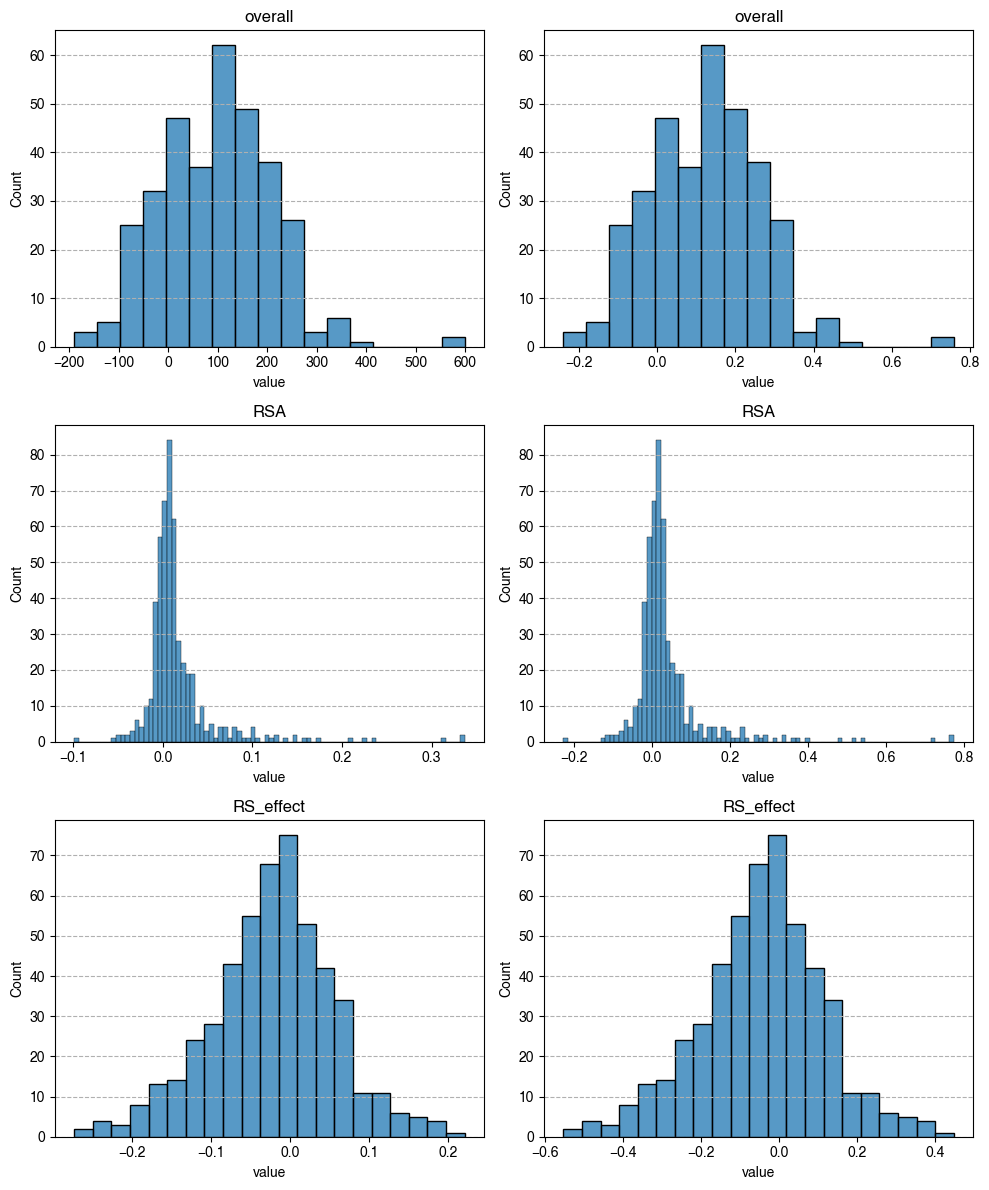

In [65]:
plot_df_vs_df_norm(df=df, df_norm=df_norm)

 43%|██████████████████████▎                             | 6/14 [00:00<00:00, 28.41it/s]

overall S1 t(11)=3.4597, p=5.336e-03(**)
overall M1 t(11)=3.0597, p=1.086e-02(*)
overall SMA t(11)=4.1741, p=1.552e-03(**)
overall PMd t(11)=2.7653, p=1.838e-02(*)
overall PMv t(11)=6.1913, p=6.799e-05(****)
overall SPLa t(11)=2.4130, p=3.443e-02(*)
overall SPLp t(11)=-2.4063, p=3.484e-02(*)


 86%|███████████████████████████████████████████▋       | 12/14 [00:00<00:00, 27.88it/s]

overall IPS t(11)=-5.7237, p=1.334e-04(***)
overall V4d t(11)=-5.5198, p=1.808e-04(***)
overall Vf t(11)=3.1820, p=8.730e-03(**)
overall Vd t(11)=-3.7369, p=3.284e-03(**)
overall Vv t(11)=-10.4387, p=4.806e-07(****)
overall POS t(11)=-0.4970, p=6.290e-01(ns)
overall PGi t(11)=1.8125, p=9.726e-02(ns)


100%|███████████████████████████████████████████████████| 14/14 [00:00<00:00, 28.19it/s]


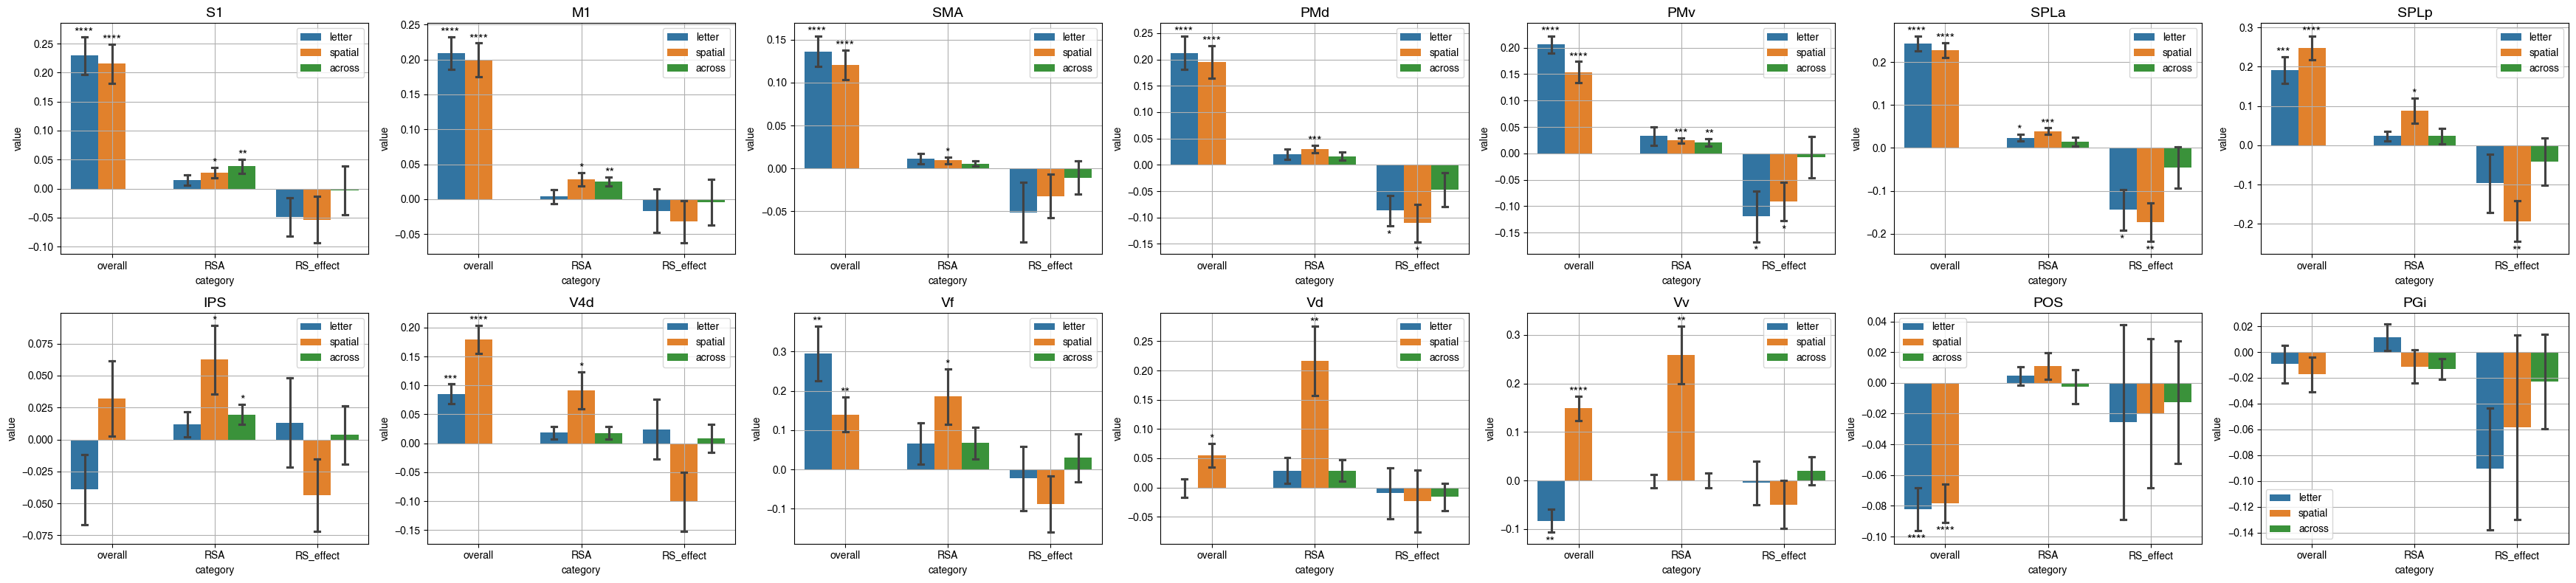

In [66]:
plot_df(df=df_norm)

---
---

### Normalization Method #2 (Wrong!)

In [ ]:
dg = df.pivot(index=['category','roi','cond'], columns=['subj'], values='value_')
dg

In [ ]:
dg = df.pivot(index=['category','roi','cond'], columns=['subj'], values='value')
## Determine whether the mean value of each row is negative
row_mean = dg.mean(axis=1)

In [ ]:
## For each ROI and condition, the data from 12 subjects were normalized 
## by setting the maximum to 1 and the minimum to 0. (Min-Max normalization)
dg_norm = dg.groupby(level='category').transform(func_normalize) # category
# dg_norm = dg.sub(dg.min(axis=1), axis=0).div(dg.max(axis=1) - dg.min(axis=1), axis=0)

## Conditionally transform the values to the range [-1, 0]
dg_norm = dg_norm.mask(row_mean.lt(0), -dg_norm)

dg_norm

In [ ]:
df_norm = dg_norm.reset_index().melt(
    id_vars=['category','roi','cond'],
    var_name='subj',
    value_name='value'
)
df_norm['cond'] = df_norm.cond.replace({
    'wRS_letter': 'letter',
    'wRS_spatial': 'spatial'
})
df_norm

---